<a href="https://colab.research.google.com/github/Ankur-Soni14/AMEX_ProductTrack/blob/main/AMEX_Round2_batsmenselection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, the required excel files are mounted using gdrive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Here, we create the qualified batsmen dataframe, using the cumulative runs criteria. We also created the 'Batting_Average' and 'Batting_Strike_Rate' coloumn which will be used later in the calculation of the cumulative score. 100s and 50s are also calculated using the 'runs' coloumn.

In [ ]:
import pandas as pd

batsman_df = pd.read_excel('/content/gdrive/MyDrive/Amex Round 2/6671501a18c55_round2_input.xlsx', sheet_name=1)
bowler_df = pd.read_excel('/content/gdrive/MyDrive/Amex Round 2/6671501a18c55_round2_input.xlsx', sheet_name=2)
match_df = pd.read_excel('/content/gdrive/MyDrive/Amex Round 2/6671501a18c55_round2_input.xlsx', sheet_name=3)

# Calculate cumulative wickets and merge with batsman_df
cumulative_runs = batsman_df.groupby('batsman_id')['runs'].sum().reset_index()
cumulative_runs.columns = ['batsman_id', 'cumulative_runs']
batsman_df = batsman_df.merge(cumulative_runs, on='batsman_id') # Merge cumulative runs into batsman_df

# Calculate average for all batsmen in batsman_df
avg = batsman_df.groupby('batsman_id')['runs'].mean().reset_index()
avg.columns = ['batsman_id', 'Batting_Average'] # Rename column to avoid conflict with 'cumulative_runs'
batsman_df = batsman_df.merge(avg, on='batsman_id') # Merge avg runs into batsman_df

# Calculate strike rate for all batsmen in batsman_df
batting_sr = batsman_df.groupby('batsman_id')['strike_rate'].mean().reset_index()
batting_sr.columns = ['batsman_id', 'Batting_Strike_Rate'] # Rename column to avoid conflict with 'cumulative_runs'
batsman_df = batsman_df.merge(batting_sr, on='batsman_id') # Merge avg runs into batsman_df

# Calculate hundreds and merge with batsman_df
hundreds = batsman_df.groupby('batsman_id')['runs'].apply(lambda x: (x >= 100).sum()).reset_index(name='hundreds')
batsman_df = batsman_df.merge(hundreds, on='batsman_id')

# Calculate fifties and merge with batsman_df
fifties = batsman_df.groupby('batsman_id')['runs'].apply(lambda x: ((x >= 50) & (x < 100)).sum()).reset_index(name='fifties')
batsman_df = batsman_df.merge(fifties, on='batsman_id')

# Filter for qualified batsmen and keep only one entry per batsman_id
qualified_batsmen = batsman_df[batsman_df['cumulative_runs'] > 100].drop_duplicates(subset='batsman_id', keep='first')

qualified_batsmen = qualified_batsmen.sort_values(by='cumulative_runs', ascending=False)

# Print the qualified batsmen DataFrame
print("Qualified Batsmen (cumulative runs > 100, one entry per batsman_id):")
print(qualified_batsmen[['batsman_id', 'cumulative_runs', 'Batting_Strike_Rate', 'Batting_Average', 'hundreds', 'fifties']]) # Display only the required columns

Qualified Batsmen (cumulative runs > 100, one entry per batsman_id):
       batsman_id  cumulative_runs  Batting_Strike_Rate  Batting_Average  \
7557      2263736             4031           115.673261        43.815217   
7987      2162782             3498           123.307835        36.061856   
2899      1749075             3203           130.018214        28.598214   
793       2076192             2984           116.674421        31.410526   
12328      313809             2798           114.388095        33.309524   
...           ...              ...                  ...              ...   
19938     8028194              101           101.750000        14.428571   
11132     8118249              101            61.163333        11.222222   
23089     5563004              101            98.355000        16.833333   
21701     8779896              101           137.925714         7.214286   
23279     6624582              101            60.564000        10.100000   

       hundreds  f

Now, the total points for each batsman is calculated using a function.

In [ ]:
import pandas as pd

# Assuming you have the qualified_batsmen DataFrame from the previous steps

def calculate_batsman_score(row):
    strike_rate_score = 0
    avg_score = 0
    hundreds_score = 0
    fifties_score = 0

    # Strike Rate score
    if row['Batting_Strike_Rate'] >= 150: # Access column using string
        strike_rate_score = 50
    elif 100 <= row['Batting_Strike_Rate'] < 150: # Access column using string
        strike_rate_score = 40
    elif 80 <= row['Batting_Strike_Rate'] < 100: # Access column using string
        strike_rate_score = 30

    # Average score - Use 'Batting_Average' instead of 'avg'
    if row['Batting_Average'] >= 50: # Use the correct column name 'Batting_Average'
        avg_score = 30
    elif 40 <= row['Batting_Average'] < 50:
        avg_score = 20
    elif 30 <= row['Batting_Average'] < 40:
        avg_score = 10
    elif row['Batting_Average'] < 30:
        avg_score = 5

    # Hundreds score
    hundreds_score = 30 if row['hundreds'] >= 3 else row['hundreds'] * 10

    # Fifties score
    if row['fifties'] >= 5:
        fifties_score = 20
    elif row['fifties'] == 4:
        fifties_score = 10
    elif row['fifties'] == 3:
        fifties_score = 10
    elif row['fifties'] == 2:
        fifties_score = 5
    elif row['fifties'] == 1:
        fifties_score = 5

    total_points = strike_rate_score + avg_score + hundreds_score + fifties_score
    return total_points

# Apply the scoring function to each row and add a new column 'total_score'
qualified_batsmen['total_points'] = qualified_batsmen.apply(calculate_batsman_score, axis=1)

# Rename the DataFrame variable 'avg' to something else to avoid conflicts
batting_average_df = avg # Rename the 'avg' DataFrame

batsman_df = batsman_df.merge(qualified_batsmen[['batsman_id', 'total_points']], on='batsman_id', how='left') # Use a left merge to keep all rows of batsman_df

# Calculate the cumulative score for all qualified batsmen
qualified_batsmen = qualified_batsmen.sort_values(by='total_points', ascending=False)
print(qualified_batsmen[['batsman_id','total_points']].to_string())

       batsman_id  total_points
7557      2263736           100
9199      3125562           100
12328      313809           100
7987      2162782           100
19331     7491224           100
2899      1749075            95
1858      4635658            95
3611      2231928            95
10265     2789646            95
2553      2275195            95
8684      2954769            90
10010     7422673            90
7649      2437021            90
6131      3057312            85
2416       363047            85
1606      2089079            85
7731      3585350            85
13135     2331475            85
24837     4170543            85
1072      4223883            85
11606     4003390            85
15168     6381962            85
18056     2654014            85
1551      1907163            80
13705     2958164            80
2648      2286472            80
8627      1776627            80
793       2076192            80
14017      325814            80
9474      5061748            80
10897   

Required batsman_id are extracted from nearbest_playing11.

In [ ]:
# prompt: how to extract all entries of a particular coloumn from a csv file using pandas as an array

import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/gdrive/MyDrive/Amex Round 2/6671502b6a89e_nearbest_playing11.csv')

# Specify the column name
column_name = 'Player_id'

# Extract the specified column as an array
column_data = df[column_name].to_numpy()

# Print the extracted column data
print(column_data)


[ 325814 1626526 1506098   82228 8250115 4171460 2275195 5652758 8986193
 8246573 7758638]


In [ ]:
nearbestplaying11_df = pd.read_csv('/content/gdrive/MyDrive/Amex Round 2/6671502b6a89e_nearbest_playing11.csv')

# Specify the batsman IDs you want to extract
batsman_ids = [ 325814, 1626526, 1506098,   82228, 8250115, 4171460, 2275195, 5652758 ,8986193, 8246573, 7758638]

# Extract the rows for the specified batsman IDs, including 'total_points'
extracted_rows = qualified_batsmen[qualified_batsmen['batsman_id'].isin(batsman_ids)][['batsman_id', 'total_points', 'Batting_Strike_Rate', 'Batting_Average', 'hundreds', 'fifties']]

print(extracted_rows.head()) # No need to specify columns again, as they are already selected

       batsman_id  total_points  Batting_Strike_Rate  Batting_Average  \
2553      2275195            95           126.458211        26.105263   
14017      325814            80           134.665926        30.444444   
1461      1626526            80           127.727889        30.411111   
2877      1506098            70           108.984545        30.772727   
22948     8250115            70           100.807619        33.333333   

       hundreds  fifties  
2553          3       14  
14017         1        7  
1461          1       17  
2877          1        3  
22948         0        6  


**Comparison-**

Now we compare the players with same cumulative score. I have given 50% weightage each to recency and consistency. For recency, I used weighted mean with higher weightage to recent matches. For consistency, I used standard deviation. Its inverse, called the consistency score has been used, as standard deviation shows an opposite trend to weighted mean with respect to a player's performance.

To make sure that the comparison is not unidimensional, for match performance, I used a similar point system as the one for cumulative score. Here, runs are used in place of average as a single match is considered: for players with the same strike rate, the one scoring 40 should get more points for that match than the one scoring 30.

For runs, I felt a linear point system would make sense (for 0-100), unlike for average. There were 2 considerations here - 1. the maximum points awarded for runs should not be >50, that way, in the maximum points scenario (50+30+50), runs would not skew the score. 2. runs <30 would be given lesser points.

This meant each run got 0.5 points from 30-100, and 0.25 for 0-30. Beyond 100, there were negligible performances so we neglect that.

Remember, runs is only a part of 1 of our 2 parameters for comparison. Absolute runs will not make as much difference as the trend of the match score.



**Which weights to use?**

I first started with the exponential function. However, it skews scores very aggressively for batsmen who have player more matches. Ex- a player who has the same match_score in his most recent match gets lesser weight because his most recent is match no. 50, while the other's is 80.

The linear model too failed. I set the weight for the oldest match to 1, most recent to 2. Everything in between was linearly scaled. However, for players with more matches, this weight got divided by a bigger number. If I didn't bind this value, the player with more matches got a linearly high weightage.

I finally settled on step function, with weights of 1 to 5 most recent matches, and 0.5 for other matches. This removed the factor of no. of matches played.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_match_score(row):
    strike_rate_score = 0
    avg_score = 0
    hundreds_score = 0
    fifties_score = 0

    # Strike Rate score
    if row['strike_rate'] >= 150:
        strike_rate_score = 50
    elif 100 <= row['strike_rate'] < 150:
        strike_rate_score = 40
    elif 80 <= row['strike_rate'] < 100:
        strike_rate_score = 30

    # Average score (for individual match, we'll use the runs scored as the average)
    runs = row['runs']
    if runs >= 30:
        avg_score = 0.5*runs
    elif runs < 30:
        avg_score = 0.25*runs

    # Hundreds score
    if runs >= 100:
        hundreds_score = 30

    # Fifties score
    if 50 <= runs < 100:
        fifties_score = 20

    total_score = strike_rate_score + avg_score + hundreds_score + fifties_score
    return total_score

def calculate_tiebreak_score(match_scores):
    # Recency score using linear weighting
    n = len(match_scores)
    recent_matches = max(5, n // 2)  # Consider last 5 matches or half, whichever is larger
    weights = np.ones(n)
    weights[:-recent_matches] = 0.5

    # Normalize weights
    weights = weights / np.sum(weights)

    # Recency score
    recency_score = np.average(match_scores, weights=weights)

    # Consistency score (unchanged)
    consistency_score = 1 / (1 + np.std(match_scores))

    # Tiebreak score (50% weightage each)
    return 0.5 * recency_score + 0.5 * consistency_score

def process_batsman_data(batsman_df):
    # Sort the DataFrame by match_date for each batsman
    batsman_df = batsman_df.sort_values(['batsman_id', 'match_dt'])

    # Calculate match score for each match
    batsman_df['match_score'] = batsman_df.apply(calculate_match_score, axis=1)

    # Calculate tiebreak score for each batsman
    tiebreak_scores = batsman_df.groupby('batsman_id')['match_score'].apply(calculate_tiebreak_score)

    return batsman_df, tiebreak_scores

# Assuming you have a DataFrame 'batsman_df' with columns: 'batsman_id', 'match_id', 'match_date', 'runs', 'strike_rate'
# And a DataFrame 'qualified_batsmen' with the batsmen who meet the minimum criteria

# Process the batsman data
processed_batsman_df, tiebreak_scores = process_batsman_data(batsman_df)

# Add tiebreak scores to qualified_batsmen DataFrame
qualified_batsmen['tiebreak_score'] = qualified_batsmen['batsman_id'].map(tiebreak_scores)

# Sort qualified_batsmen by tiebreak_score
qualified_batsmen = qualified_batsmen.sort_values('total_points', ascending=False)

print("Qualified batsmen with tiebreak scores:")
print(qualified_batsmen[['batsman_id', 'total_points', 'tiebreak_score']].to_string())

Qualified batsmen with tiebreak scores:
       batsman_id  total_points  tiebreak_score
7557      2263736           100       31.766698
12328      313809           100       26.420712
7987      2162782           100       29.696200
19331     7491224           100       29.834914
9199      3125562           100       29.439266
3611      2231928            95       24.982499
10265     2789646            95       40.462186
2553      2275195            95       24.310722
1858      4635658            95       24.376192
2899      1749075            95       25.615212
8684      2954769            90       27.375055
10010     7422673            90       27.878742
7649      2437021            90       26.307088
24837     4170543            85       40.922004
18056     2654014            85       26.035117
15168     6381962            85       20.629580
11606     4003390            85       23.541421
1072      4223883            85       24.199379
2416       363047            85       23.387465


From above tiebreak scores, We also try to plot --

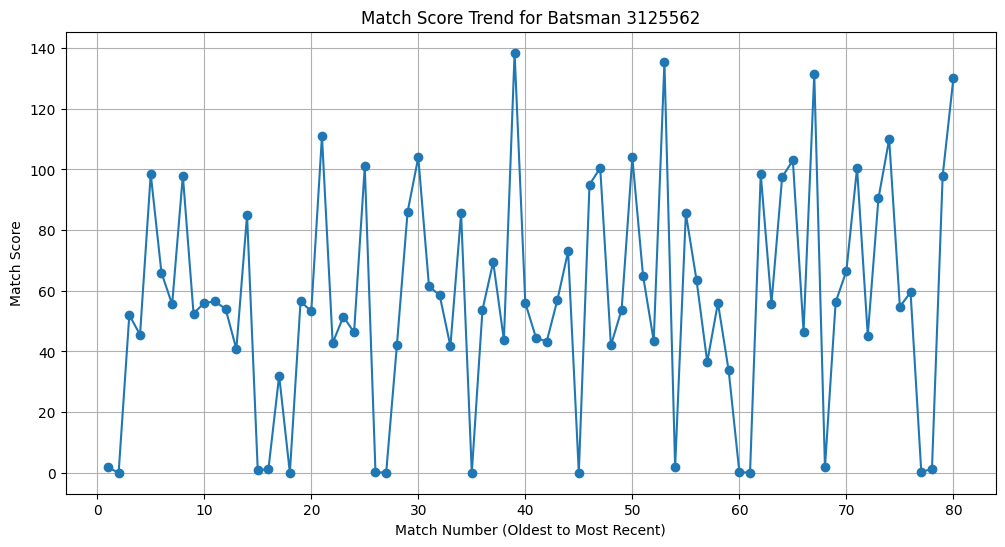

In [ ]:
def plot_match_score_trend(batsman_df, batsman_id):
    player_data = batsman_df[batsman_df['batsman_id'] == batsman_id]
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(player_data) + 1), player_data['match_score'], marker='o')
    plt.title(f'Match Score Trend for Batsman {batsman_id}')
    plt.xlabel('Match Number (Oldest to Most Recent)')
    plt.ylabel('Match Score')
    plt.grid(True)
    plt.show()

# Function to plot match score trend for a given batsman_id
def plot_batsman_trend(batsman_id):
    if batsman_id in processed_batsman_df['batsman_id'].values:
        plot_match_score_trend(processed_batsman_df, batsman_id)
    else:
        print(f"No data found for batsman_id {batsman_id}")

plot_batsman_trend(3125562)